In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs
        reload(dt)

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    # %run "fig2.ipynb"

    print('Done')

Done


In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [3]:
@utility.report
def plot_monkey_VAF_cca(ax, ax_hist, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1][:2]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1][:2]
    
    field = monkey_defs.areas[2]+'_rates'
    VAFs1 = []
    VAFs2 = []
    for df1,df2 in zip(side1df,side2df):
        VAFs1_, VAFs2_ = dt.VAF_pyal(
            df1, field, monkey_defs.exec_epoch, 
            df2, field, monkey_defs.exec_epoch)
        print(VAFs1_)
        

/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/jcc319/multi_a

Executed: `get_full_monkey_data` in 14.4s


/home/jcc319/multi_animal_alignment/packages/pyaldata/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


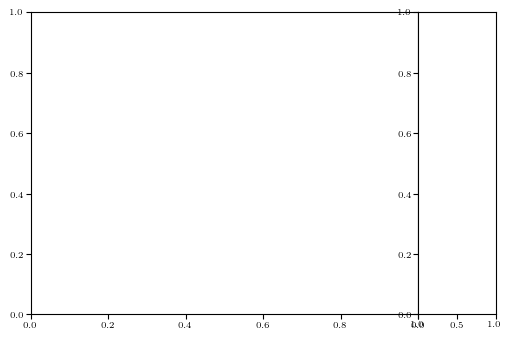

In [4]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    # plot_monkey_VAF_cca(ax,ax_, full_list_MCx[10:13], allDFs_MCx)
    
    # plt.show()

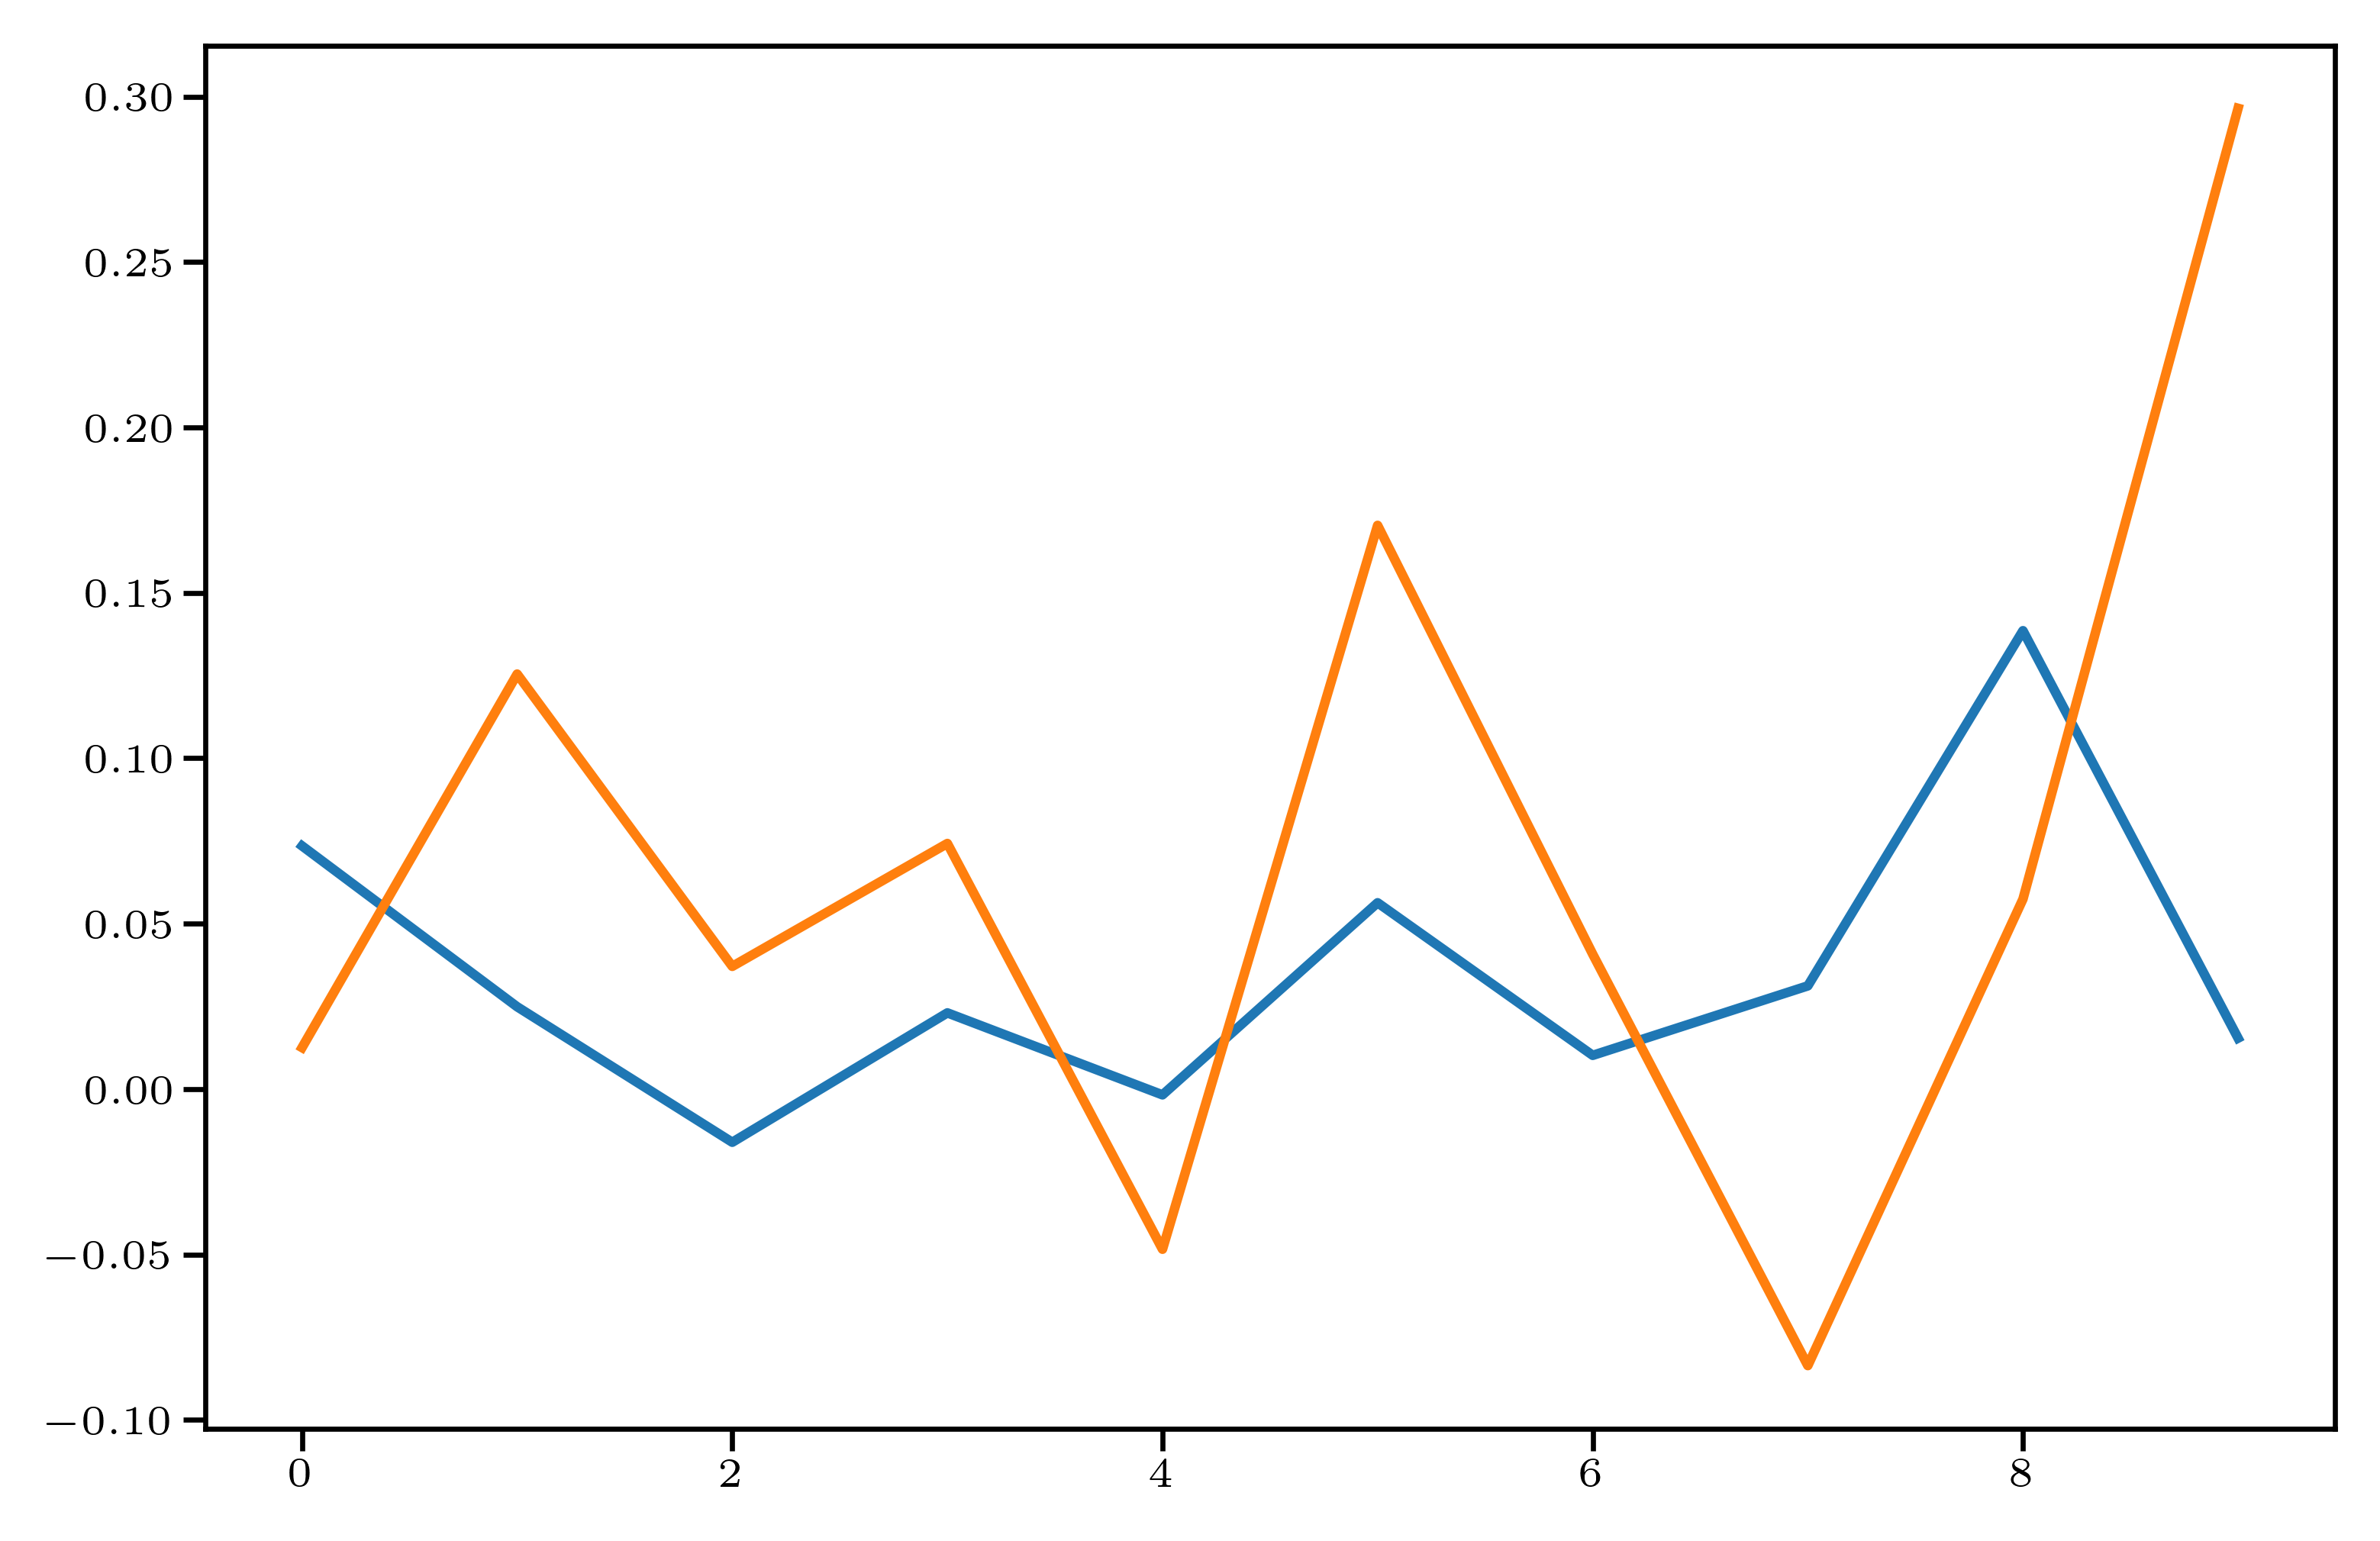

In [5]:
# full_list_MCx, allDFs_MCx = get_full_monkey_data()
pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if J<=I or animal1 == animal2: continue  # to repetitions
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
        pairFileList1.append((I,J))

side1df = [allDFs_MCx[i] for i,_ in pairFileList1][:1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1][:1]

field = monkey_defs.areas[2]+'_rates'
VAFs1 = []
VAFs2 = []
for df1,df2 in zip(side1df,side2df):
    VAFs1_, VAFs2_ = dt.VAF_pyal(
        df1, field, monkey_defs.exec_epoch, 
        df2, field, monkey_defs.exec_epoch)
    VAFs1.append(VAFs1_)
    VAFs2.append(VAFs2_)

plt.figure()

for VAFs1_ in VAFs1:
    plt.plot((VAFs1_))

for VAFs2_ in VAFs2:
    plt.plot((VAFs2_))


In [70]:
field1= field
field2 =field
epoch1 = monkey_defs.exec_epoch
epoch2 = monkey_defs.exec_epoch
n_components = 10

df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
rates_1 = np.concatenate(df1[field1].values, axis=0)
rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
rates_1_C = rates_1_model.components_
df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');
pca_1_data = np.concatenate(df1['_pca'].values, axis=0)

df2 = pyal.restrict_to_interval(df2, epoch_fun=epoch2)
rates_2 = np.concatenate(df2[field2].values, axis=0)
rates_2_model = PCA(n_components=n_components, svd_solver='full').fit(rates_2)
rates_2_C = rates_2_model.components_
df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field2, '_pca');
pca_2_data = np.concatenate(df2['_pca'].values, axis=0)


# same number of timepoints in both matrices
n_samples = min ([pca_1_data.shape[0], pca_2_data.shape[0]])
pca_1_data = pca_1_data[:n_samples,:]
pca_2_data = pca_2_data[:n_samples,:]

X_1 = rates_1[:n_samples,:]
X_2 = rates_1[:n_samples,:]

A, B, *_ = dt.canoncorr(pca_1_data, pca_2_data, fullReturn=True)
VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
print(VAFs1)

print(A.shape, pca_1_data.shape)

X = rates_1
pca = pca_1_data #samples x features
A #cca proj
C = rates_1_C #pca proj




[ 0.07350177  0.02488232 -0.01607764  0.02303469 -0.00174731  0.05631816
  0.01019597  0.03119975  0.13855988  0.01539963]
(10, 10) (2790, 10)


(2790, 10)


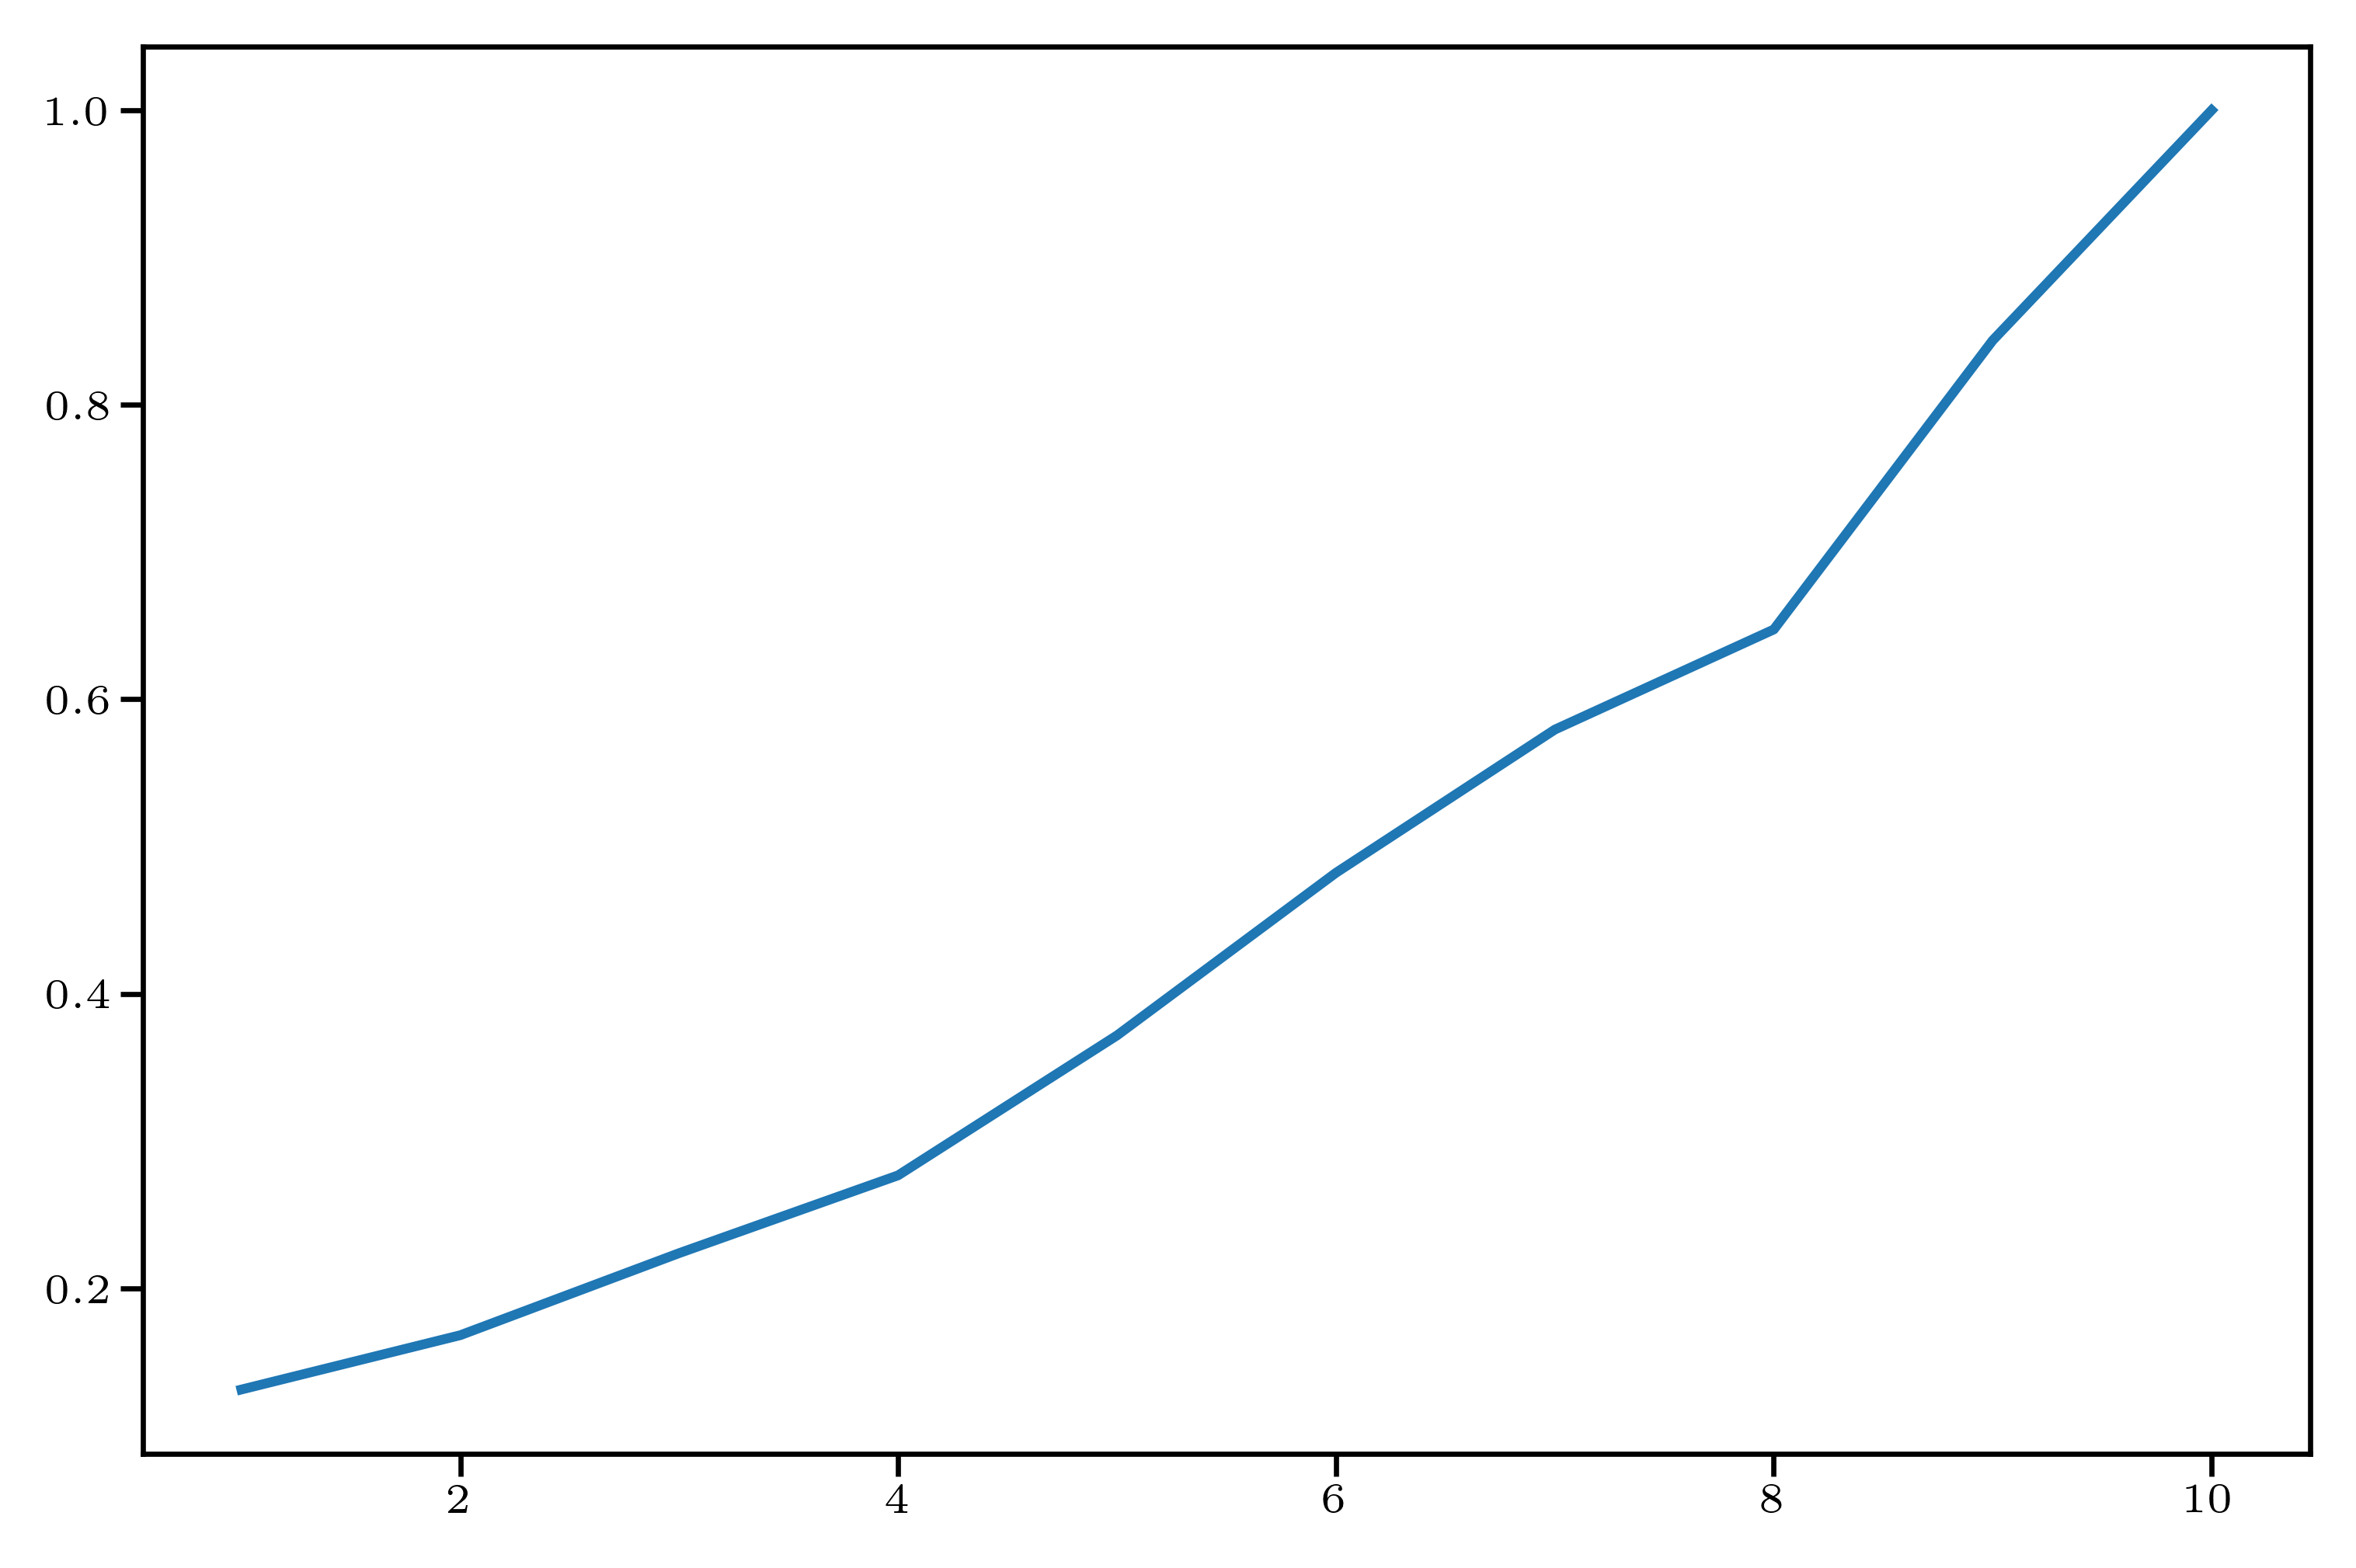

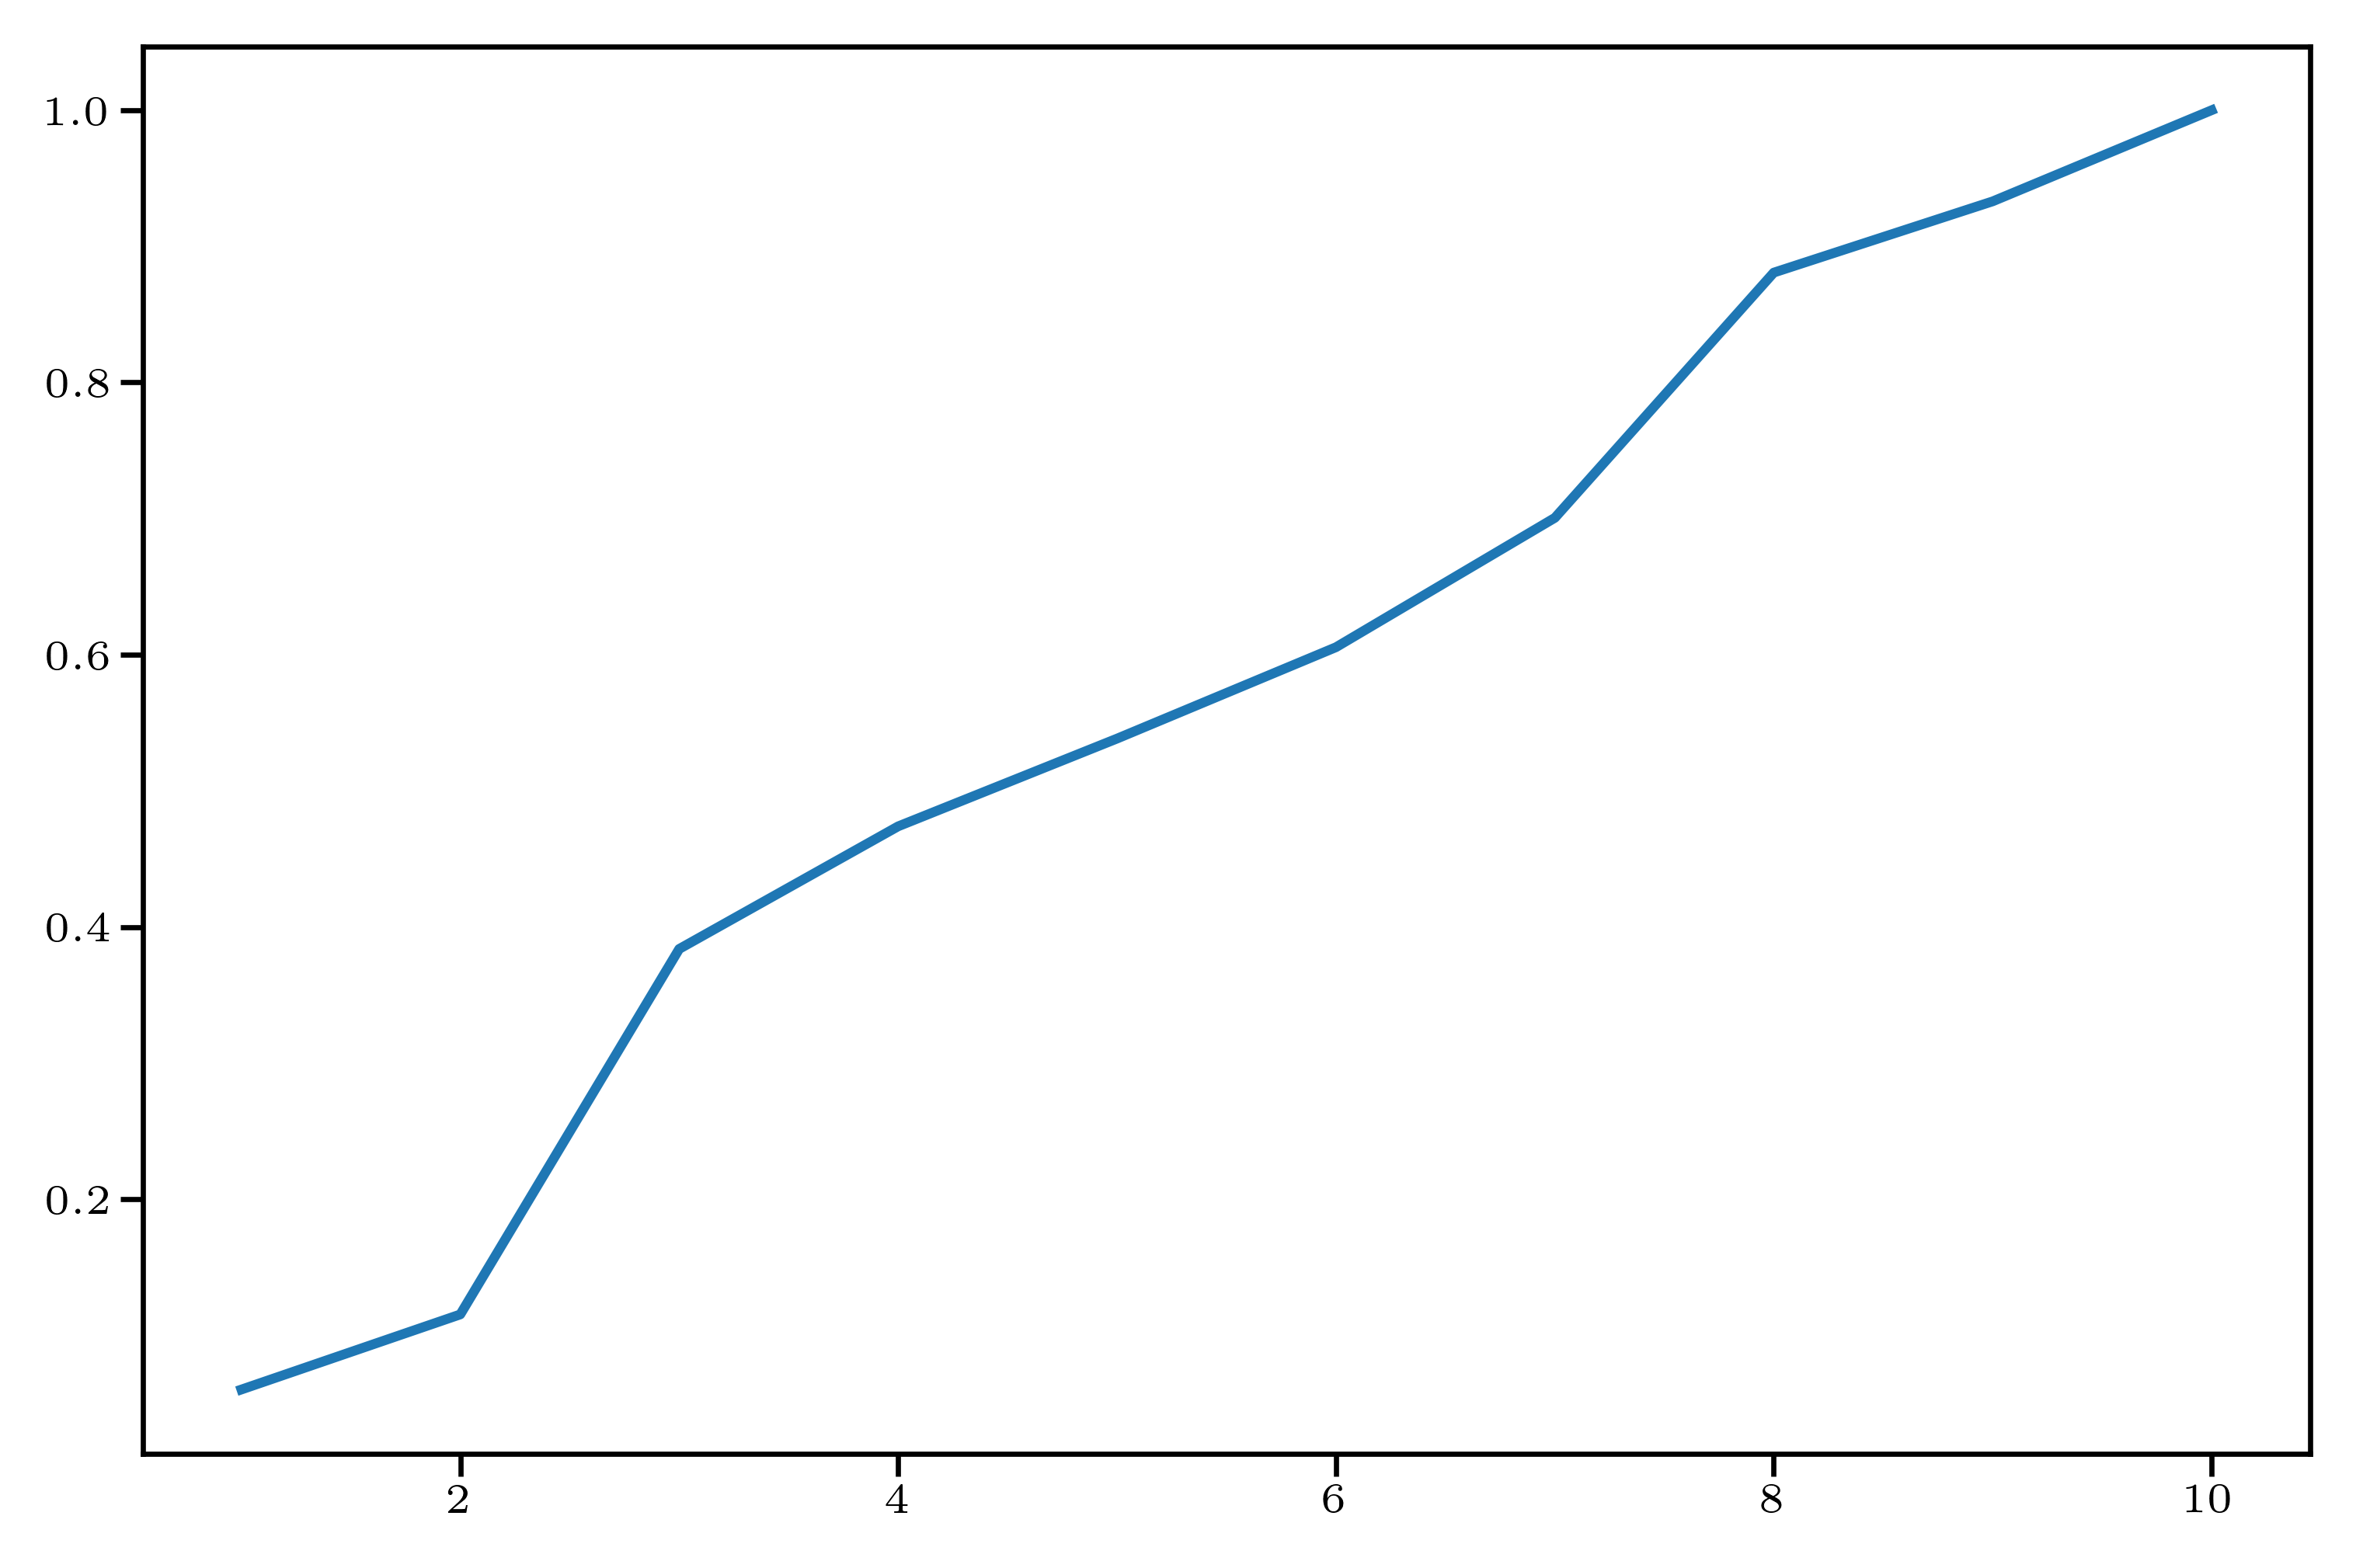

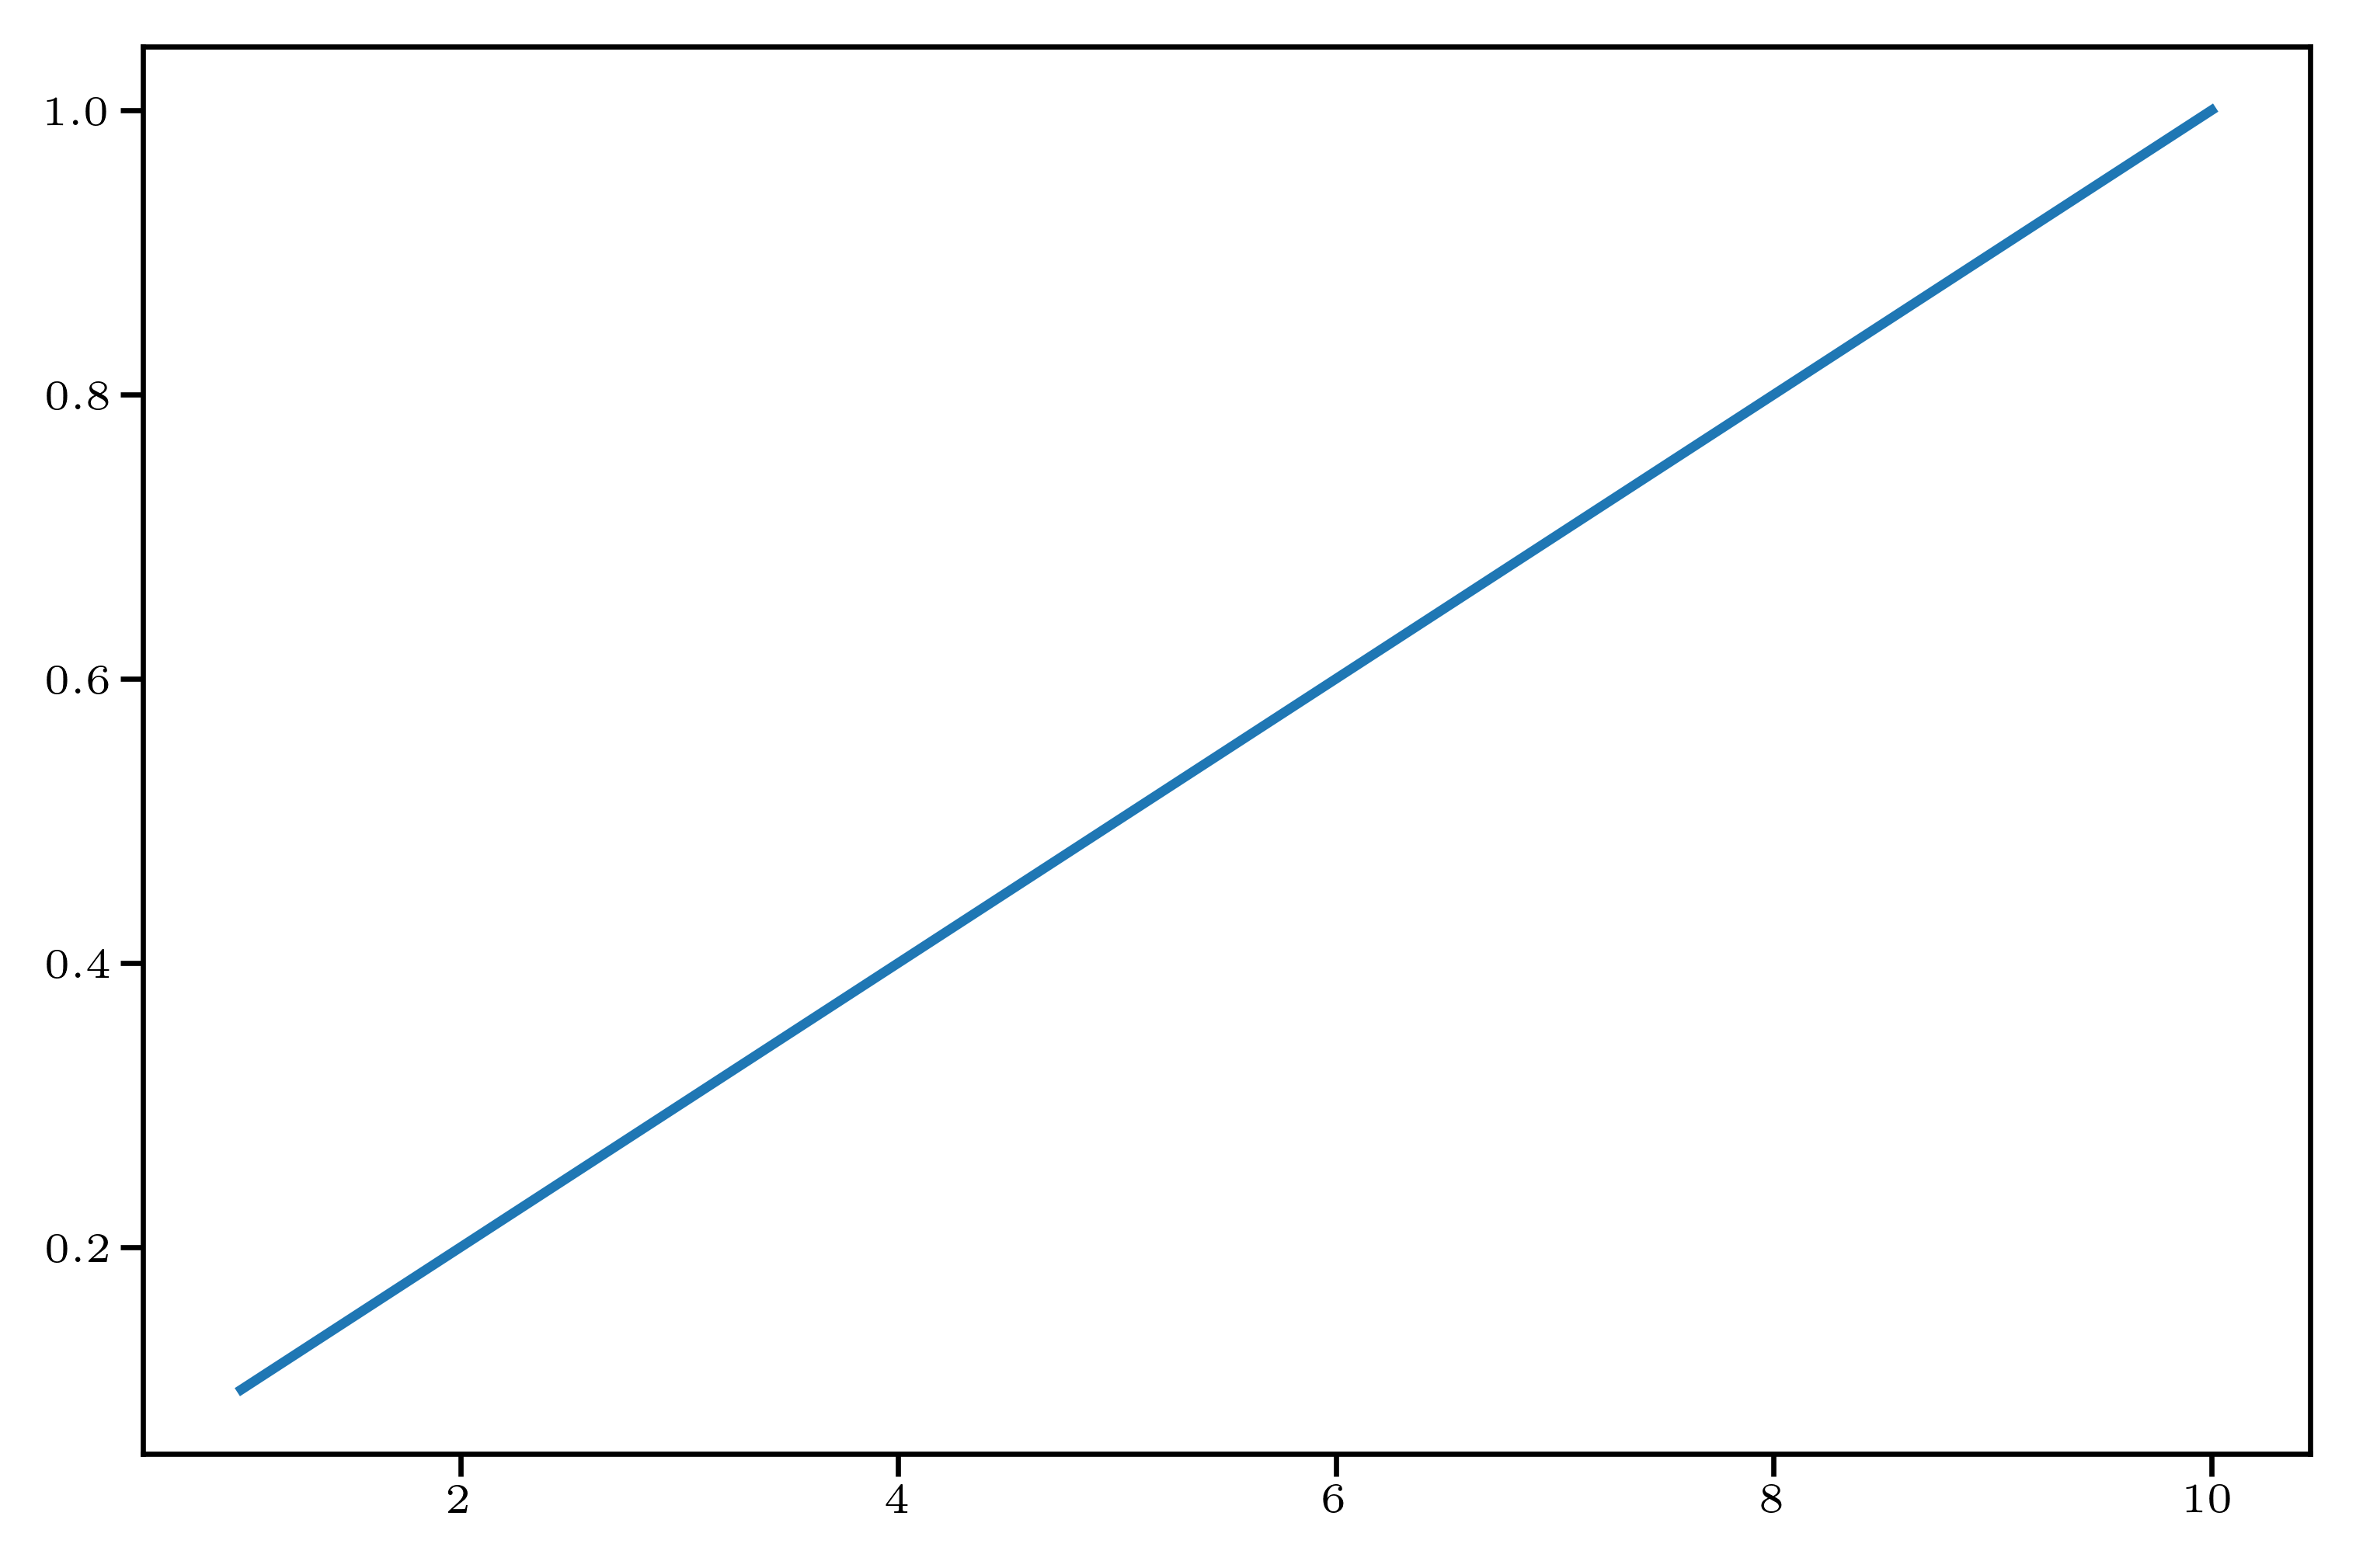

In [72]:
import scipy

#project cumulative dimensions, limit ncomps
vafs=[]
vafs2 = []
for i in range(1,monkey_defs.n_components + 1):
    W = A[:,:i] #nfeatures x ncomp    
    W_orth = scipy.linalg.orth(W) #already normalized
    vaf = np.trace(W_orth.T @ np.cov(pca.T) @ W_orth)
    vafs.append(vaf)
vafs = np.array(vafs)
plt.figure()
plt.plot(range(1,monkey_defs.n_components + 1), vafs/vafs[-1])

#project cumulative dimensions, limit nfeatures
vafs=[]
vafs2 = []
for i in range(1,monkey_defs.n_components + 1):
    W = A[:i].T #nfeatures x ncomp    
    W_orth = scipy.linalg.orth(W) #already normalized
    vaf = np.trace(W_orth.T @ np.cov(pca.T) @ W_orth)
    vafs.append(vaf)
vafs = np.array(vafs)
plt.figure()
plt.plot(range(1,monkey_defs.n_components + 1), vafs/vafs[-1])

#project leave-one-out dimensions
vafs=[]
vafs2 = []
W = A #nfeatures x ncomp    
W = W / np.linalg.norm(W, axis=0)
tot_vaf = np.trace(W.T @ np.cov(pca.T) @ W)

for i in range(monkey_defs.n_components):
    W_ = np.delete(A, i, axis = 1) #nfeatures x ncomp  
    vaf = np.trace(W_.T @ np.cov(pca.T) @ W_)
    vafs.append(vaf)
vafs = np.cumsum(vafs)

plt.figure()
plt.plot(range(1,monkey_defs.n_components + 1), vafs/vafs[-1])
print(pca_1_data.shape)

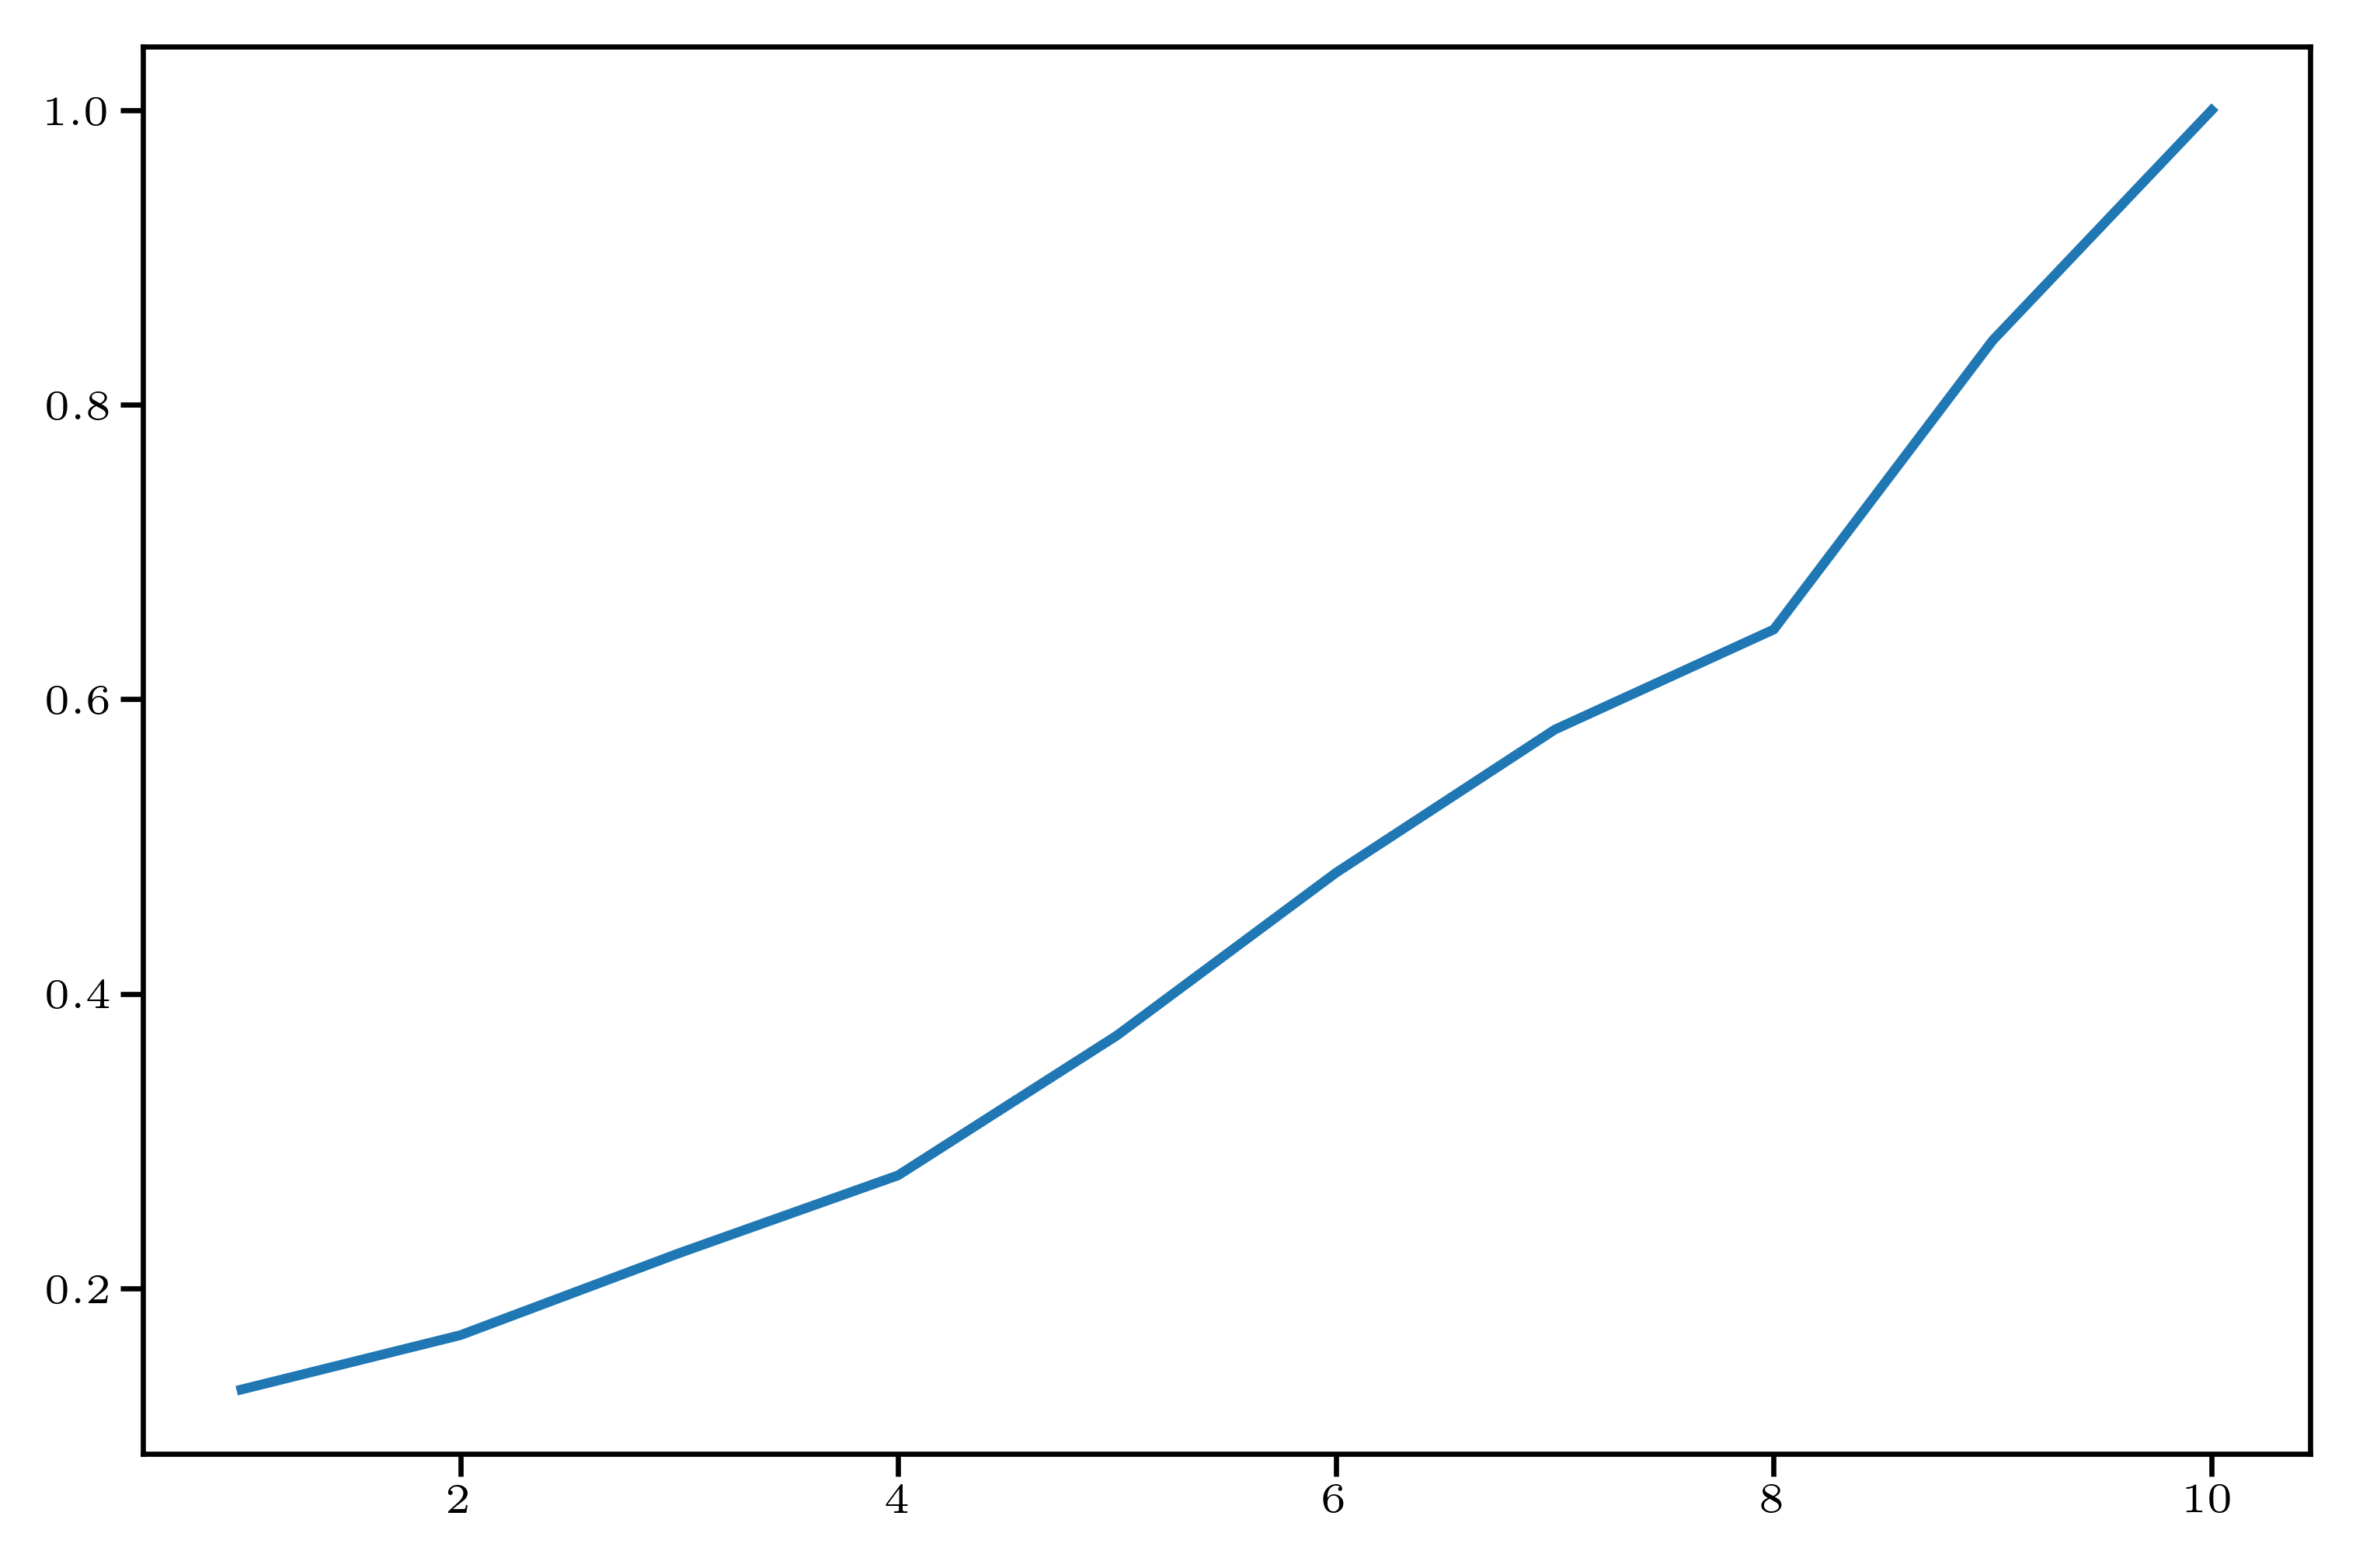

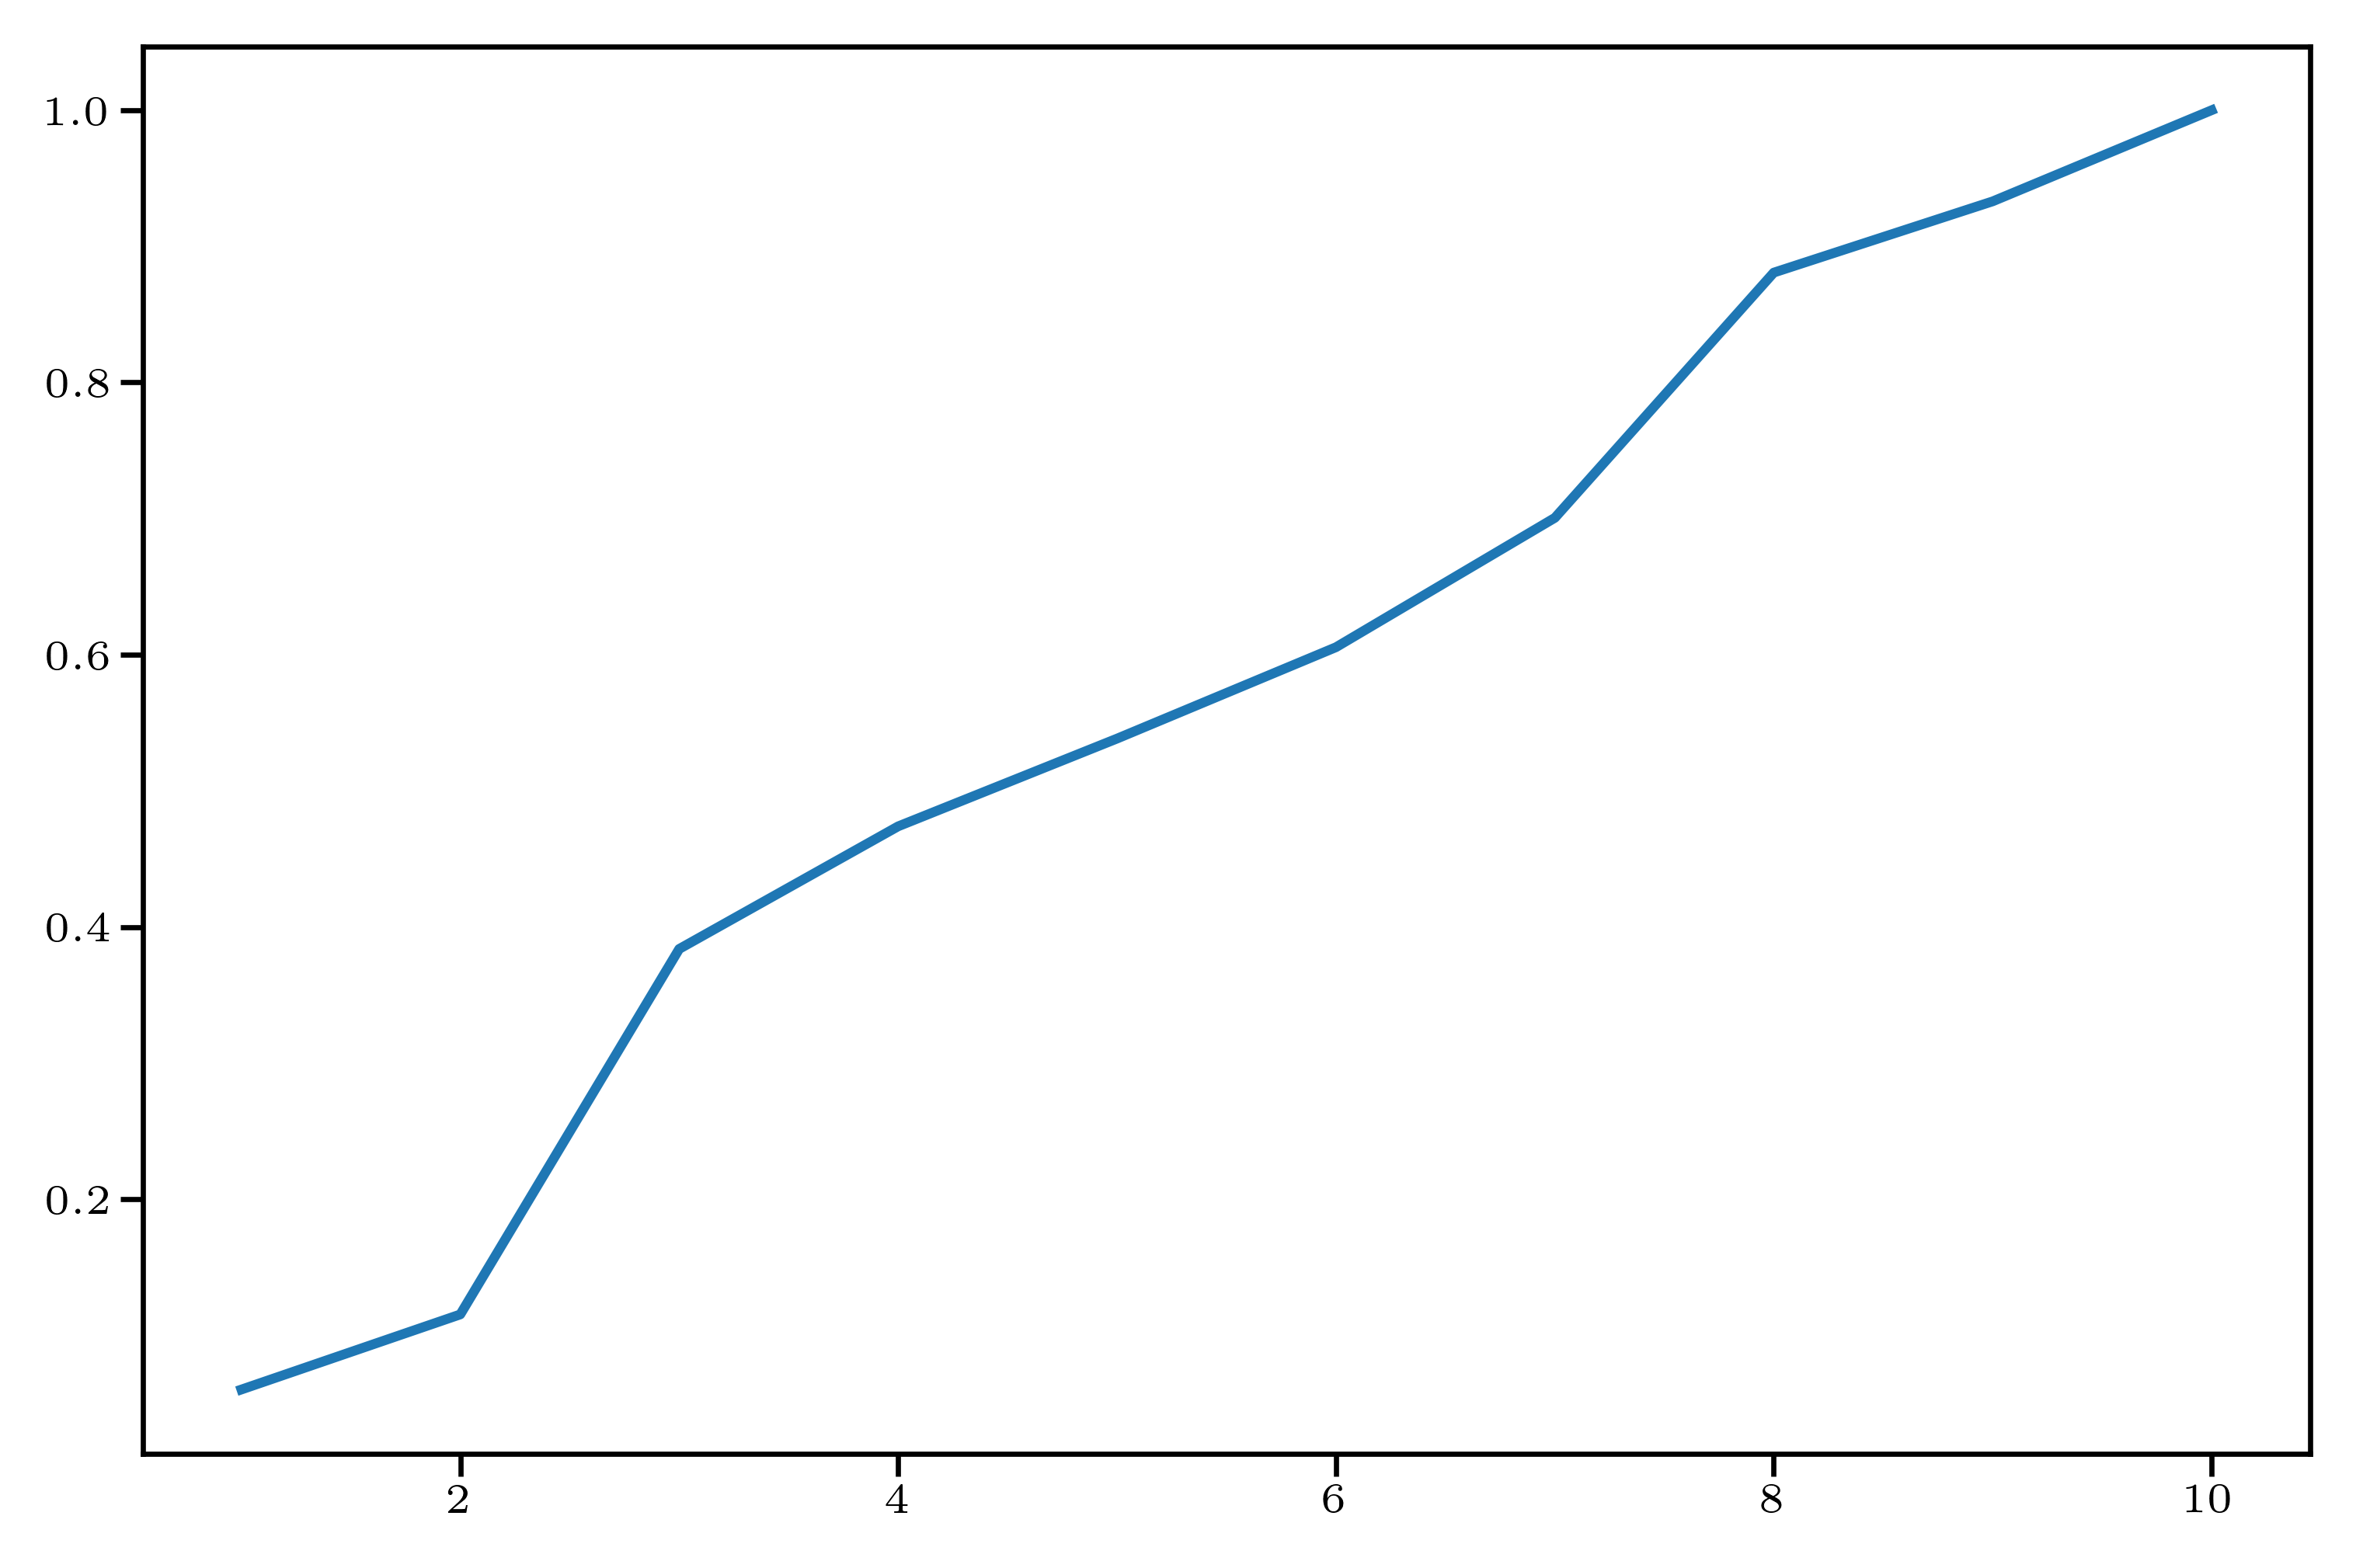

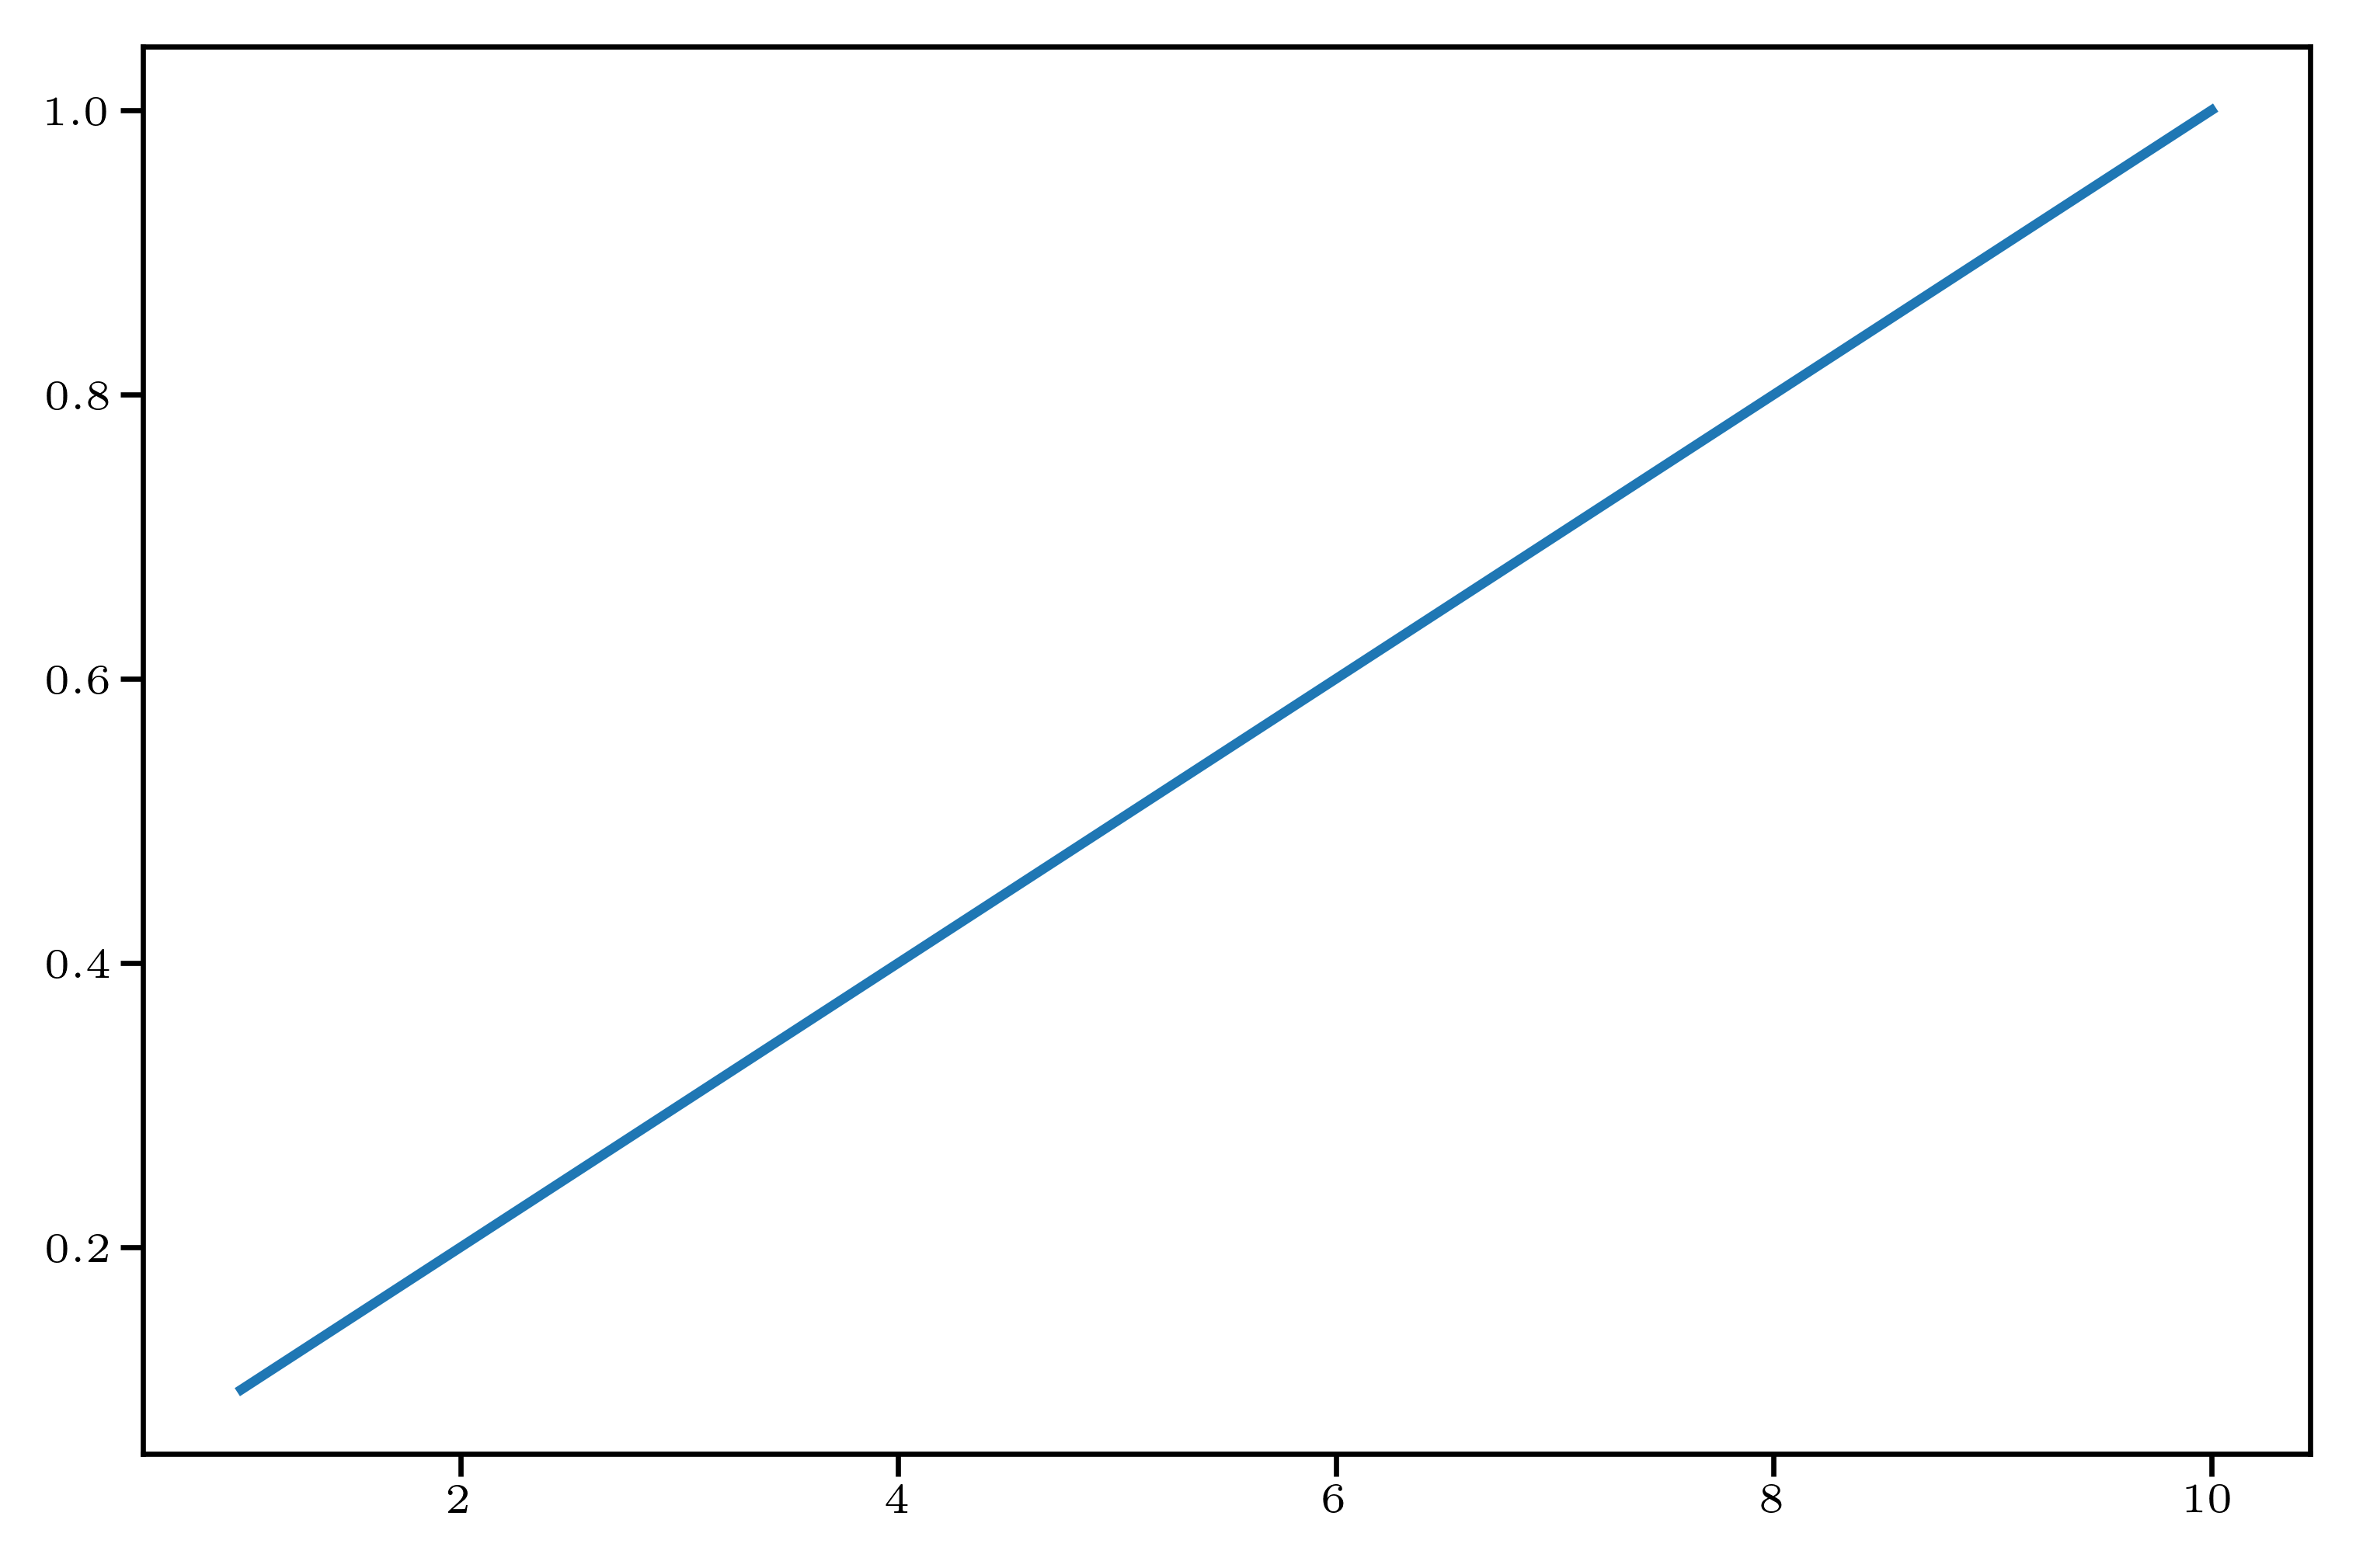

In [80]:
import scipy

X = rates_1
pca = pca_1_data #samples x features
A #cca proj
C = rates_1_C #pca proj

#project cumulative dimensions, limit ncomps
vafs=[]
vafs2 = []
for i in range(1,monkey_defs.n_components + 1):
    W = A[:,:i] #nfeatures x ncomp    
    W_orth = scipy.linalg.orth(W) #already normalized
    proj = C.T @ W_orth
    vaf = np.trace(proj.T @ np.cov(X.T) @ proj)
    vafs.append(vaf)
vafs = np.array(vafs)
plt.figure()
plt.plot(range(1,monkey_defs.n_components + 1), vafs/vafs[-1])

#project cumulative dimensions, limit nfeatures
vafs=[]
vafs2 = []
for i in range(1,monkey_defs.n_components + 1):
    W = A[:i].T #nfeatures x ncomp    
    W_orth = scipy.linalg.orth(W) #already normalized
    proj = C.T @ W_orth
    vaf = np.trace(proj.T @ np.cov(X.T) @ proj)
    vafs.append(vaf)
vafs = np.array(vafs)
plt.figure()
plt.plot(range(1,monkey_defs.n_components + 1), vafs/vafs[-1])

#project cumulative dimensions, limit nfeatures
vafs=[]
vafs2 = []
W = A #nfeatures x ncomp    
W = W / np.linalg.norm(W, axis=0)
proj = C.T @ W
tot_vaf = np.trace(proj.T @ np.cov(X.T) @ proj)

for i in range(monkey_defs.n_components):
    W_ = np.delete(A, i, axis = 1) #nfeatures x ncomp  
    proj = C.T @ W_
    vaf = np.trace(proj.T @ np.cov(X.T) @ proj)
    vafs.append(vaf)
vafs = np.cumsum(vafs)

plt.figure()
plt.plot(range(1,monkey_defs.n_components + 1), vafs/vafs[-1])